In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

In [3]:
df = pd.read_csv("steam-200k.csv", header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])

In [4]:
df.head()

UserID                        Game    Action  Hours  Other
0  151603712  The Elder Scrolls V Skyrim  purchase    1.0      0
1  151603712  The Elder Scrolls V Skyrim      play  273.0      0
2  151603712                   Fallout 4  purchase    1.0      0
3  151603712                   Fallout 4      play   87.0      0
4  151603712                       Spore  purchase    1.0      0

Инфомация для действий "play" наиболее аткуальная.

In [5]:
df.loc[df['Action'] == 'play'].describe()

UserID         Hours    Other
count  7.048900e+04  70489.000000  70489.0
mean   1.058812e+08     48.878063      0.0
std    7.150365e+07    229.335236      0.0
min    5.250000e+03      0.100000      0.0
25%    4.934256e+07      1.000000      0.0
50%    9.169067e+07      4.500000      0.0
75%    1.556738e+08     19.100000      0.0
max    3.099031e+08  11754.000000      0.0

In [ ]:
Проверим играет ли игрок каждый раз, покупая игру.

In [6]:
values = df.groupby(['UserID', 'Action']).size()
values.head()

UserID  Action  
5250    play         6
        purchase    21
76767   play        20
        purchase    36
86540   play        15
dtype: int64

In [ ]:
Видно, что не все пользователи играют в игры, которые купили.

In [15]:
total_purchases = len(df.loc[df['Action'] == 'purchase'])
total_plays_info = len(df.loc[df['Action'] == 'play'])
print(f'Количество игр: {len(df.Game.unique())}')
print(f'Количество пользователей: {len(df.UserID.unique())}')
print(f'Общее количество покупок: {total_purchases}')
print(f'Информация о количестве запусков: {total_plays_info}')

Количество игр: 5155
Количество пользователей: 12393
Общее количество покупок: 129511
Информация о количестве запусков: 70489


In [16]:
nb_games = 10

In [20]:
df_purchase = df.loc[df['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]


In [27]:
df_play = df.loc[df['Action'] == 'play']
hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

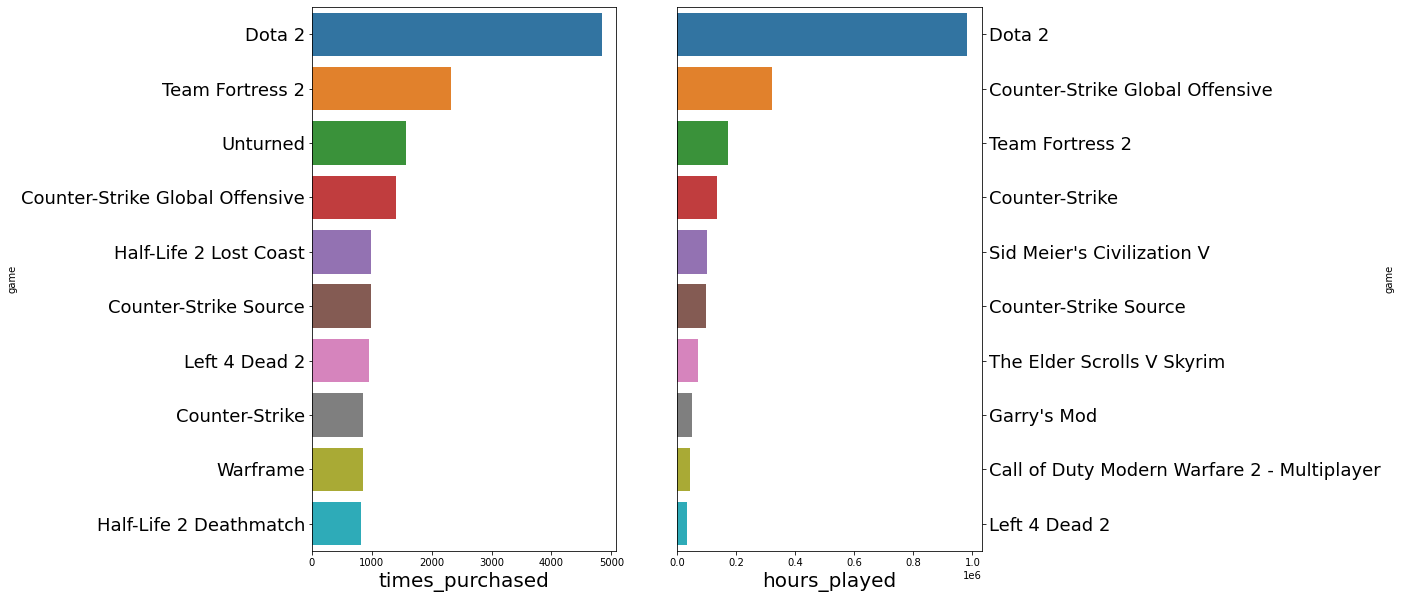

In [29]:
fig, ax =plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)

Взглянем на количество самых активных пользователей по часам игры.

<AxesSubplot:xlabel='hours_played', ylabel='game'>

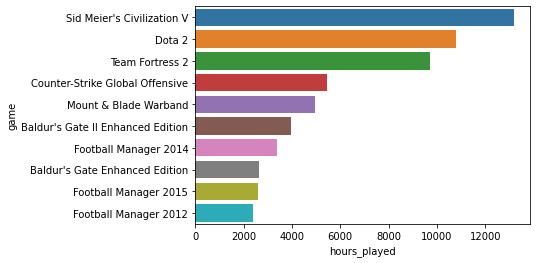

In [31]:
top = 10
user_counts = df.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)[0:top]
mask = df['UserID'].isin(user_counts.index)
df_infos_user = df.loc[mask].loc[df['Action'] == 'play']
hours_played = df_infos_user.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

sns.barplot(y = 'game', x = 'hours_played', data = hours_played)

<AxesSubplot:xlabel='Hours', ylabel='Game'>

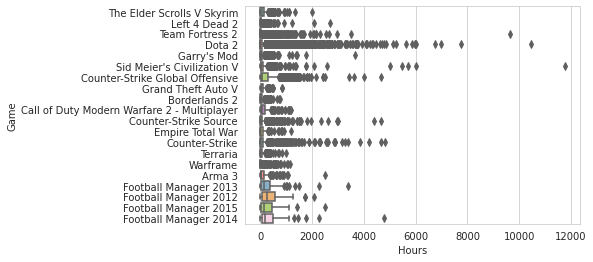

In [32]:
nb_top_games = 20
hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
top_played_games = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_top_games]

mask = df['Game'].isin(top_played_games['game'])

df_infos_user = df.loc[mask].loc[df['Action'] == 'play'][['Hours', 'Game']]


sns.set_style("whitegrid")
sns.boxplot(x="Hours", y="Game", data=df_infos_user, palette="Set3")

Как видно некоторые игры очень близки к среднему количеству сыгранных игр.
Тогда как есть (например Civilization 5), которые имеют огромное количество время игры.

Классифицируем пользователей. Для этого используем:

1. Количество купленных игр в зависимости от количества часов в игре
2. Количество сыгранных игр в зависимости от количетсва сыгранных часов
3. Количество действий в зависимости  от часов игры

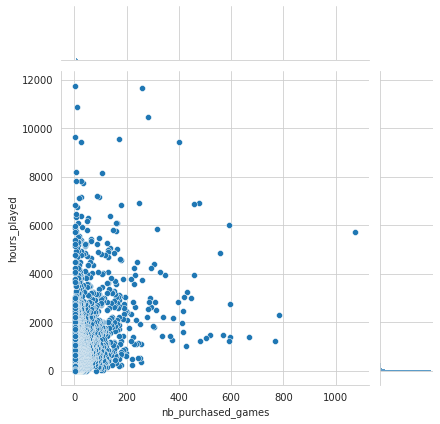

In [34]:
df_purchased_games = df.loc[df['Action'] == 'purchase']
df_played_games = df.loc[df['Action'] == 'play']

#количетсво игр купленных пользователем
user_counts = df_purchased_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#Количество часов которое играл пользователей
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#создание df
user_df_purchased_games = pd.DataFrame({'UserID': user_counts.index, 'nb_purchased_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})te

#Объединение записи пользователя с количеством сыгранных часов и количеством купленных игр
data = pd.merge(user_df_purchased_games, user_df_hours_played, on='UserID')
sns.jointplot(x="nb_purchased_games", y="hours_played", data=data

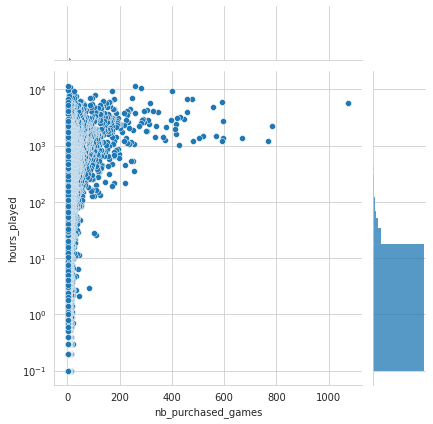

In [35]:
g = sns.jointplot(x="nb_purchased_games", y="hours_played", data=data )
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g


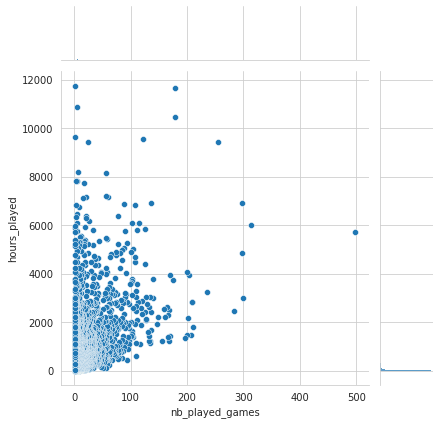

In [36]:
#Вычислим количество игр в которые играл пользователь
user_counts = df_played_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
# Вычисленим количество часов которые он играл
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

user_df_played_games = pd.DataFrame({'UserID': user_counts.index, 'nb_played_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})

data = pd.merge(user_df_played_games, user_df_hours_played, on='UserID')

sns.jointplot(x="nb_played_games", y="hours_played", data=data )

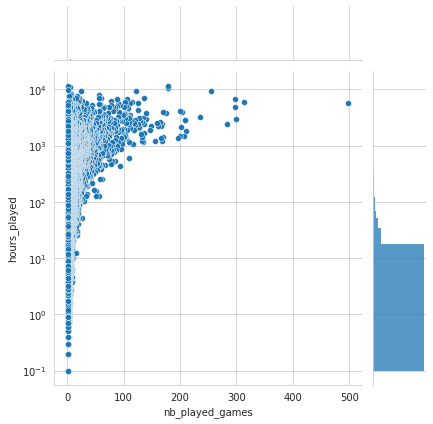

In [40]:
g = sns.jointplot(x="nb_played_games", y="hours_played", data=data )
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

<AxesSubplot:>

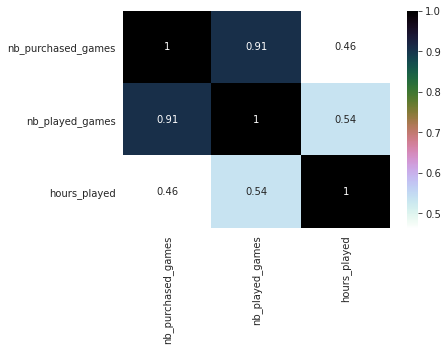

In [38]:
temp = pd.merge(user_df_purchased_games, data, on='UserID')
temp = temp.copy()
del temp['UserID'] #don't need this for k mean
sns.heatmap(temp.corr(),annot=True,cmap='cubehelix_r')

Видна сильная корреляция между количеством сыграных игр и количесвом купленных.